# Develop minERR

In [1]:
from Bio import SeqIO, SeqRecord
from mineer.pipeline import Project
from mineer.utils import File, Sample, ReadPair
from mineer.mineer import minEER
from glob import glob
import numpy as np
import os, random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import jit

# Inputs

In [2]:
filepaths = sorted(glob('fastqs/*'))[:4]
fwd_format = '_1.fastq'
rev_format = '_2.fastq'
mal = 100
mae = 1e-2
nreads = 5000
filepaths

['fastqs/SRR9660307_1.fastq',
 'fastqs/SRR9660307_2.fastq',
 'fastqs/SRR9660321_1.fastq',
 'fastqs/SRR9660321_2.fastq']

In [4]:
import numba

In [ ]:
numba.config.

In [3]:
# Create project
print('Creating project...')
project = Project(filepaths, fwd_format, rev_format, nreads, mal, mae, outdir='truncated')
# 1) Ingest reads
print('Ingesting reads...')
project.getReadsandSamples()
# 2) Subsample
print('Subsetting reads...')
project.sampleReads()
read_subset = project.all_sub
# 3) Run minEER on subset
print('Running minEER on subset...')
project.mineerReads(read_subset)
# 4) Determine global truncation positions
print('Calculating global truncation positions...')
project.calcPos()
# 5) Truncate all reads to global positions and filter out read pairs that don't pass QC
print('Truncating files to global positions...')
project.truncAndFilter()
# # 6) Save truncated sequences
print('Saving truncated files...')
project.writeFiles()

Creating project...
Ingesting reads...
Subsetting reads...
Running minEER on subset...
Calculating global truncation positions...
Truncating files to global positions...
Saving truncated files...


In [12]:
len(project.rev_reads)

7223

In [9]:
len(project.passing_readpairs)

3247

In [23]:
trimstart, trimend = map(int, project.fwd_pos)
trimstart, trimend

(0, 254)

In [17]:
(0, 20) == 'a'

False

In [14]:
project = Project(filepaths, fwd_format, rev_format, nreads, outdir='truncated')

In [15]:
print('Ingesting reads...')
project.getReads()
# 2) Subsample
print('Subsetting reads...')
project.sampleReads()

Ingesting reads...
Subsetting reads...


In [13]:
project.nreads

10000

In [10]:
len(project.fwd_reads), len(project.rev_reads)

(7223, 7223)

In [11]:
%%time
# Create project
project = Project(filepaths, fwd_format, rev_format, nreads, mal, mae)
# 1) Ingest reads
project.getReads()
# 2) Subsample
project.sampleReads()
# 3) Truncate reads
for r in project.all_sub:
    r.trim()

CPU times: user 16.3 s, sys: 96.8 ms, total: 16.4 s
Wall time: 16.4 s


In [15]:
fwd_trimpos = np.array([r.trimpos for r in project.fwd_sub if r.pass_qc])
rev_trimpos = np.array([r.trimpos for r in project.rev_sub if r.pass_qc])

In [22]:
np.median([r.trimpos for r in project.rev_sub if r.pass_qc], 0)

array([  0., 131.])

In [20]:
np.mean([r.pass_qc for r in project.fwd_sub])

0.8154

In [21]:
np.mean([r.pass_qc for r in project.rev_sub])

0.0908

In [28]:
f = project.files[0]

In [35]:
f.filepath

'fastqs/SRR9660346_1.fastq'

In [36]:
os.path.isdir('truncated')

False

In [46]:
bool(project.fwd_sub[0].trimmed)

True

In [48]:
len(project.fwd_reads) + len(project.rev_reads)

59358

# Process

In [5]:
%%time
"""Ingest files"""
# Get files
files = [File(f, 'f' if f.endswith('_1.fastq') else 'r', mal, mae) for f in filepaths]
# Extract reads
reads = [r for f in files for r in f.reads]
# Subsample
subreads = random.sample(reads, nreads)

"""Trim"""
# Trim each subsampled read
for r in subreads:
    r.trim()

CPU times: user 19.3 s, sys: 215 ms, total: 19.5 s
Wall time: 19.6 s


In [51]:
"""Collect phred data"""
max_len = max([len(r.untrimmed.record) for r in subreads])
phreds = np.empty((nreads, max_len))
phreds[:] = np.nan
directions = [None] * nreads

for i in range(nreads):
    r = subreads[i]
    # Add direction
    directions[i] = r.file.direction
    # Add phred
    phred = r.untrimmed.phred
    length = r.untrimmed.length
    phreds[i, :length] = phred
phred_df = pd.DataFrame(phreds)
# Add direction
phred_df = phred_df.join(pd.Series(directions).rename('direction')).rename_axis(index='read', columns='pos')
phred_df.head()

pos,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,300,direction
read,,,,,,,,,,,,,,,,,,,,,
0,12.0,32.0,34.0,34.0,34.0,24.0,37.0,36.0,36.0,37.0,...,8.0,13.0,13.0,8.0,8.0,17.0,25.0,10.0,NaN,r
1,34.0,34.0,34.0,34.0,34.0,38.0,38.0,38.0,31.0,34.0,...,7.0,7.0,13.0,8.0,8.0,8.0,7.0,7.0,7.0,f
2,34.0,34.0,34.0,34.0,34.0,38.0,38.0,38.0,38.0,38.0,...,7.0,7.0,7.0,7.0,7.0,7.0,11.0,19.0,11.0,f
3,34.0,34.0,34.0,34.0,34.0,38.0,38.0,38.0,37.0,32.0,...,7.0,12.0,8.0,8.0,8.0,8.0,11.0,13.0,12.0,f
4,34.0,31.0,32.0,34.0,34.0,38.0,35.0,32.0,24.0,34.0,...,7.0,13.0,7.0,7.0,7.0,7.0,7.0,7.0,NaN,r


In [52]:
"""Stack for boxplots"""
# Add direction, melt
melted = phred_df.reset_index().melt(['read', 'direction'], value_name='phred')
melted.head()

,read,direction,pos,phred
0,0,r,0,12.0
1,1,f,0,34.0
2,2,f,0,34.0
3,3,f,0,34.0
4,4,r,0,34.0


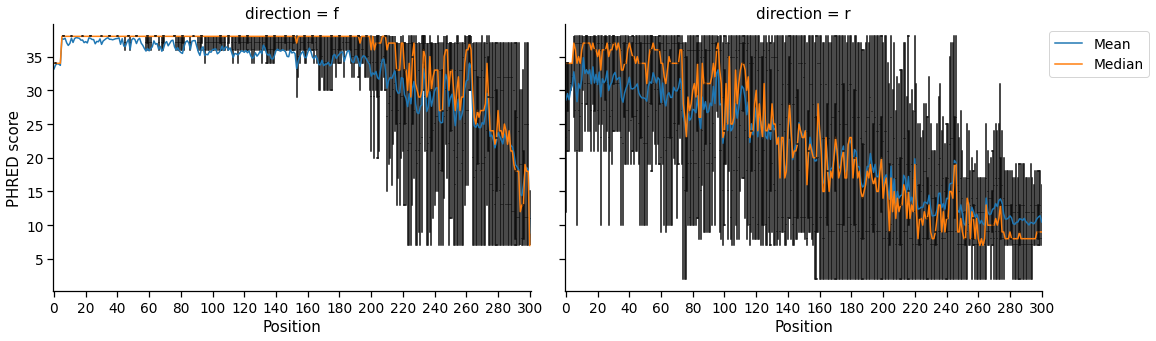

In [87]:
"""Plot"""
with sns.plotting_context('notebook', font_scale=1.25):
    g = sns.FacetGrid(melted, col='direction', col_order=['f', 'r'], height=5, aspect=1.5)
    g.map(sns.boxplot, 'pos', 'phred', color='.1', showfliers=False, order=range(max_len), width=.1, whis=1)
    for ax, direction in zip(g.axes.ravel(), g.col_names):
        data = phred_df[phred_df.direction.eq(direction)]
        ax.plot(data.mean(), lw=1.5, label='Mean')
        ax.plot(data.median(), lw=1.5, label='Median')
    ax.legend(bbox_to_anchor=(1, 1))
    g.set(xticks=range(max_len)[::20])
    g.set_xlabels('Position')
    g.set_ylabels('PHRED score')
plt.show()

In [85]:
"""Get pos"""
trimposes = np.array([r.trimpos for r in subreads if r.pass_qc])
trimposes.mean(0)

array([  0.31821998, 189.53316541])

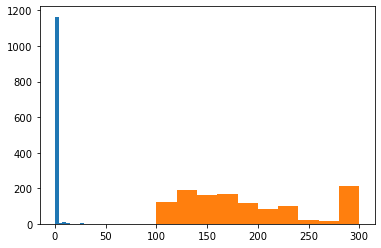

In [84]:
plt.hist(trimposes[:, 0])
plt.hist(trimposes[:, 1])
plt.show()

In [105]:
ee = [.1, .01, .01, .3, .5]
mal = 1

In [106]:
def eerspace(ee, mal):
    # Ensure np.array()
    ee = np.array(ee)
    # Initialize matrix
    n_pos = len(ee)
    eer_space = np.empty((n_pos, n_pos))
    eer_space[:] = np.nan
    # For each starting position
    for start in range(n_pos - mal):
        # Get expected error profile from this start
        ee_start = ee[start:]
        # Calculate the expected errors starting at this position
        eers = ee_start.cumsum() / (np.arange(len(ee_start)) + 1)
        # Only take the expected errors starting at the minimum acceptable length
        eers_mal = eers[mal:]
        # Update the search space
        eer_space[start, (start + mal) :] = eers_mal
    return eer_space

In [107]:
# Ensure np.array()
ee = np.array(ee)
# Initialize matrix
n_pos = len(ee)
eer_space = np.empty((n_pos, n_pos))
eer_space[:] = np.nan
# For each starting position
for start in range(n_pos - mal):
    # Get expected error profile from this start
    ee_start = ee[start-1:]
    # Calculate the expected errors starting at this position
    eers = ee_start.cumsum() / (np.arange(len(ee_start)) + 1)
    # Only take the expected errors starting at the minimum acceptable length
    eers_mal = eers[mal:]
    # Update the search space
    eer_space[start, (start + mal) :] = eers_mal

AttributeError: 'Read' object has no attribute 'record'

In [202]:
%%time
oldpos = []
for r in project.fwd_reads:
    ee = r.untrimmed.ee
    p = minEER(ee)
    oldpos.append(p)

CPU times: user 11.9 s, sys: 48.6 ms, total: 12 s
Wall time: 12 s


In [199]:
%%time
newpos = []
for r in project.fwd_reads:
    ee = r.untrimmed.ee
    p = newminEER(ee)
    newpos.append(p)

CPU times: user 5.06 s, sys: 41.3 ms, total: 5.1 s
Wall time: 5.11 s


In [180]:
ee = np.array([1, 2, 3])

In [203]:
oldpos[:10]

[(0, 271),
 (None, None),
 (None, None),
 (0, 217),
 (0, 222),
 (None, None),
 (0, 298),
 (1, 225),
 (80, 205),
 (0, 213)]

In [204]:
newpos[:10]

[(0, 271),
 (None, None),
 (None, None),
 (0, 217),
 (0, 222),
 (None, None),
 (0, 298),
 (1, 225),
 (80, 205),
 (0, 213)]

In [21]:
minEER(project.fwd_reads[8].untrimmed.ee)

(80, 206)

In [24]:
project.fwd_reads[8]

In [31]:
Record(File('test/test_files/test_read.fastq', 'f').reads[0])

NameError: name 'Record' is not defined

In [226]:
@jit(nopython=True)
def eerspace(ee, mal):
    # Initialize matrix
    n_pos = len(ee)
    eer_space = np.empty((n_pos, n_pos))
    eer_space[:] = np.nan
    # Compute the cumulative sum of the expected errors
    cumsum_ee = np.cumsum(ee)
    # Get normalizing vector to compute EER at each position
    norm = np.arange(n_pos) + 1
    # Initialize first start
    eer_space[0, mal:] = (cumsum_ee / norm)[mal:]

    # For each starting position
    for start in range(1, n_pos - mal):
        # Get cumulative sum from this start position
        cumsum_ee_start = cumsum_ee[start:]

        # Calculate the expected errors from this start position
        eers = (cumsum_ee_start - cumsum_ee[start - 1]) / norm[:-start]
        # Only take the expected errors starting at the minimum acceptable length
        eers_mal = eers[mal:]
        # Update the search space
        eer_space[start, (start + mal) :] = eers_mal
    return eer_space

def newminEER(ee, mal=100, mae=1e-3):
    """
    Exhaustive expected error rate (EER) search for a sequence
    Finds the longest sequence with an EER<=thresh with length>=mal
    Inputs:
    | ee <array>: Vector of expected errors
    | mal <int>: Minimum acceptable length of sequence
    | mae <float>: Minimum acceptable EER threshold
    Outputs:
    | {start, end}_pos: Positions where subsequence starts and ends
    """
    # Ensure np.array()
    ee = np.array(ee)
    # Calculate expected error space
    eer_space = eerspace(ee, mal)

    """Find max length sequence below threshold"""
    # Filter out nans to avoid warning about trying to evaluate np.nan<thresh
    idxs = np.array(np.where(np.isfinite(eer_space)))
    threshed = eer_space[idxs[0], idxs[1]] <= mae
    # If no subsequences, return None
    if not threshed.any():
        start_pos, end_pos = None, None
    else:
        # Start and end indices that satisfy threshold
        start_ids, end_ids = idxs[:, threshed]
        # Find longest subsequence
        max_idx = np.argmax(end_ids - start_ids)
        start_pos, end_pos = start_ids[max_idx], end_ids[max_idx]
        end_pos += 1
    return start_pos, end_pos 

In [227]:
ee = [1, 2, 3]
newminEER(ee, 0, np.inf)

(0, 3)

In [229]:
ee[0: 2]

[1, 2]

In [156]:
ee = [.1, .01, .01, .3, .5]
mal = 1

ee = np.array(ee)
# Initialize matrix
n_pos = len(ee)
eer_space = np.empty((n_pos, n_pos))
eer_space[:] = np.nan
# Compute the cumulative sum of the expected errors
cumsum_ee = ee.cumsum()
# Get normalizing vector to compute EER at each position
norm = np.arange(n_pos) + 1
# Initialize first start
eer_space[0, mal:] = (cumsum_ee / norm)[mal:]

# For each starting position
for start in range(1, n_pos - mal):
    # Get cumulative sum from this start position
    cumsum_ee_start = cumsum_ee[start:]

    # Calculate the expected errors from this start position
    eers = (cumsum_ee_start - cumsum_ee[start - 1]) / norm[:-start]
    # Only take the expected errors starting at the minimum acceptable length
    eers_mal = eers[mal:]
    # Update the search space
    eer_space[start, (start + mal) :] = eers_mal
eer_space  

array([[       nan, 0.055     , 0.04      , 0.105     , 0.184     ],
       [       nan,        nan, 0.01      , 0.10666667, 0.205     ],
       [       nan,        nan,        nan, 0.155     , 0.27      ],
       [       nan,        nan,        nan,        nan, 0.4       ],
       [       nan,        nan,        nan,        nan,        nan]])

In [152]:
(cumsum_ee / norm)[mal:]

array([1.5, 2. ])

In [131]:
cumsum_ee_start - cumsum_ee[start - 1]

array([2, 5])

In [132]:
norm[:-start]

array([1, 2])

In [53]:
norm

array([0.01      , 0.10666667, 0.205     ])

In [54]:
start + mal

3